In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from pathlib import Path
data_path = Path("data")
train_dir = data_path / "train"
test_dir = data_path / "test"
train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

In [4]:
IMG_SIZE = 256

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [5]:
dataset = dset.ImageFolder(train_dir, transform=manual_transforms)
test_dataset = dset.ImageFolder(test_dir, transform=manual_transforms)

In [6]:
class_names = dataset.classes

In [7]:
dataset.class_to_idx

{'benign keratosis-like lesions': 0, 'melanocytic nevi': 1, 'melanoma': 2}

In [8]:
train_idx = torch.tensor(dataset.targets) == 2
test_idx = torch.tensor(test_dataset.targets) == 2
dset_train = Subset(dataset, list(np.where(train_idx==1)[0]))
dset_test = Subset(test_dataset, list(np.where(test_idx==1)[0]))

In [9]:
len(dset_train), len(dset_test)

(782, 331)

In [10]:
final_dset = ConcatDataset([dset_train, dset_test])
len(final_dset)

1113

In [11]:
dataloader = DataLoader(final_dset, batch_size=64, shuffle=False)

Text(0.5, 1.0, 'melanoma')

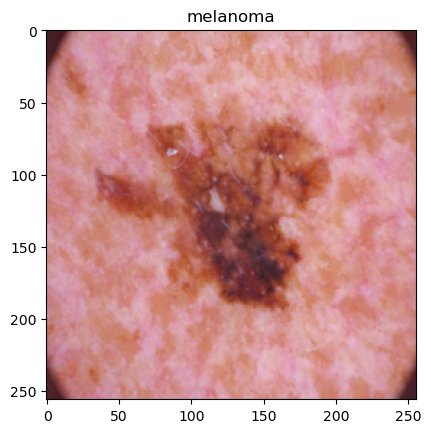

In [12]:
image, label = next(iter(dataloader))
plt.imshow(image[0].permute(1,2,0))
plt.title(class_names[label[0]])

In [8]:
# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

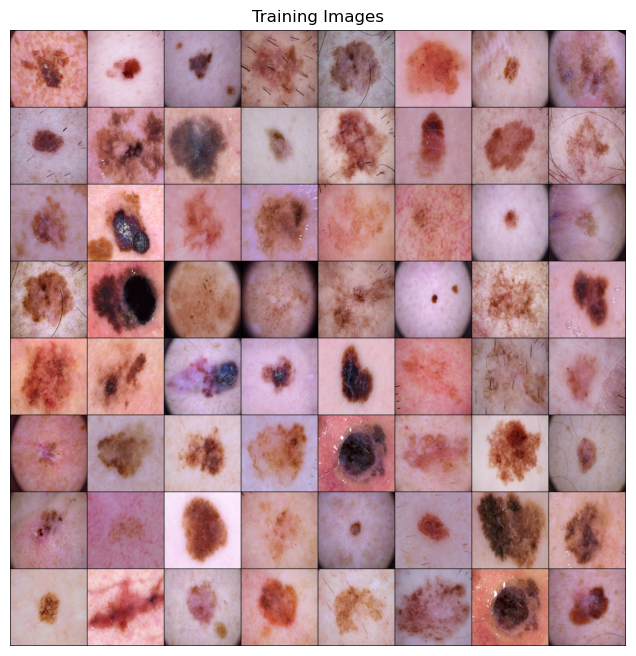

In [15]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(nz, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, nc, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [9]:
netG = Generator().to(device)

# # Handle multi-GPU if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
# netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=524288, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(nc, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = image_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [11]:
netD = Discriminator().to(device)

# # Handle multi-GPU if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [12]:
criterion = nn.BCEWithLogitsLoss().to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [14]:
checkpoint = torch.load("models/RALSGAN_mel_1000_epoch.pth")
netG.load_state_dict(checkpoint["generator_state_dict"])
netD.load_state_dict(checkpoint["discriminator_state_dict"])
optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
last_epoch = checkpoint["epoch"]
criterion = checkpoint["loss_fn"]

In [23]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(last_epoch, num_epochs):
    netG.train()
    netD.train()
    for i, (images,_) in enumerate(dataloader):
        
        valid = Variable(Tensor(images.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(images.shape[0], 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(images.type(Tensor))
        optimizerG.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (images.shape[0], nz))))
        gen_imgs = netG(z)
        real_pred = netD(real_imgs).detach()
        fake_pred = netD(gen_imgs)
        g_loss = criterion(fake_pred - real_pred, valid)
        g_loss = criterion(netD(gen_imgs), valid)
        g_loss.backward()
        optimizerG.step()


        optimizerD.zero_grad()
        # Predict validity
        real_pred = netD(real_imgs)
        fake_pred = netD(gen_imgs.detach())
        
        real_loss = criterion(real_pred - fake_pred, valid)
        fake_loss = criterion(fake_pred - real_pred, fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizerD.step()
        

        # Output training stats
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            # with torch.no_grad():
                # fake = netG(Variable(Tensor(np.random.normal(0, 1, (images.shape[0], nz))))).detach().cpu()
            img_list.append(gen_imgs)
        iters += 1

Starting Training Loop...
[Epoch 960/1000] [Batch 0/18] [D loss: 0.733590] [G loss: 0.602869]
[Epoch 960/1000] [Batch 1/18] [D loss: 0.698073] [G loss: 0.596069]
[Epoch 960/1000] [Batch 2/18] [D loss: 0.673935] [G loss: 0.653041]
[Epoch 960/1000] [Batch 3/18] [D loss: 0.694337] [G loss: 0.636555]
[Epoch 960/1000] [Batch 4/18] [D loss: 0.713984] [G loss: 0.633512]
[Epoch 960/1000] [Batch 5/18] [D loss: 0.684609] [G loss: 0.625056]
[Epoch 960/1000] [Batch 6/18] [D loss: 0.674237] [G loss: 0.611367]
[Epoch 960/1000] [Batch 7/18] [D loss: 0.649076] [G loss: 0.596902]
[Epoch 960/1000] [Batch 8/18] [D loss: 0.680704] [G loss: 0.580412]
[Epoch 960/1000] [Batch 9/18] [D loss: 0.665031] [G loss: 0.587651]
[Epoch 960/1000] [Batch 10/18] [D loss: 0.682482] [G loss: 0.556795]
[Epoch 960/1000] [Batch 11/18] [D loss: 0.813174] [G loss: 0.601130]
[Epoch 960/1000] [Batch 12/18] [D loss: 0.736069] [G loss: 0.583236]
[Epoch 960/1000] [Batch 13/18] [D loss: 0.732329] [G loss: 0.620650]
[Epoch 960/1000] [

In [24]:
torch.save({'epoch': num_epochs,
            'generator_state_dict': netG.state_dict(),
            'discriminator_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'loss_fn': criterion}, 
	    'models/RALSGAN_mel_1000_epoch.pth')

In [41]:
new_img =netG(Variable(Tensor(np.random.normal(0, 1, (64, nz)))))

In [42]:
len(new_img)

64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


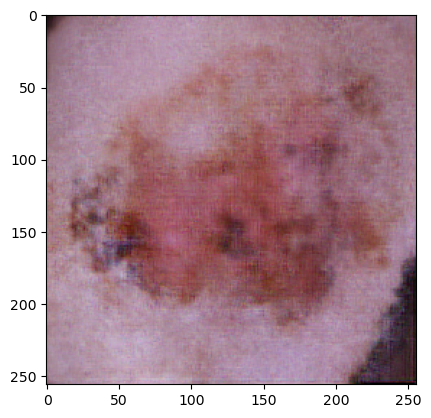

In [43]:
plt.imshow(np.transpose(new_img[0].cpu().detach().numpy(),(1,2,0)))

In [ ]:
for i in range(384,len(new_img)+384):
    vutils.save_image(new_img[i-384], f"mel/image{i+1}.jpg")

In [19]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(new_img).cpu(),(1,2,0)))
plt.show()

NameError: name 'dataloader' is not defined